<a href="https://colab.research.google.com/github/ayushtripath17/CNN-parkinsons-detection/blob/main/CNN_approach_Parkinsons_drawings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN Approach

In [ ]:
import torch
from torch import nn

torch.__version__

'2.3.0+cu121'

In [ ]:
! pip install kaggle

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download kmader/parkinsons-drawings

Dataset URL: https://www.kaggle.com/datasets/kmader/parkinsons-drawings
License(s): Attribution-NonCommercial-NoDerivatives 4.0 International (CC BY-NC-ND 4.0)
 80% 33.0M/41.4M [00:00<00:00, 84.2MB/s]
100% 41.4M/41.4M [00:00<00:00, 79.5MB/s]


In [ ]:
! unzip parkinsons-drawings.zip

Archive:  parkinsons-drawings.zip
  inflating: drawings/spiral/testing/healthy/V01HE01.png  
  inflating: drawings/spiral/testing/healthy/V02HE01.png  
  inflating: drawings/spiral/testing/healthy/V03HE1.png  
  inflating: drawings/spiral/testing/healthy/V04HE01.png  
  inflating: drawings/spiral/testing/healthy/V05HE01.png  
  inflating: drawings/spiral/testing/healthy/V06HE01.png  
  inflating: drawings/spiral/testing/healthy/V07HE01.png  
  inflating: drawings/spiral/testing/healthy/V08HE01.png  
  inflating: drawings/spiral/testing/healthy/V09HE01.png  
  inflating: drawings/spiral/testing/healthy/V10HE01.png  
  inflating: drawings/spiral/testing/healthy/V11HE01.png  
  inflating: drawings/spiral/testing/healthy/V55HE12.png  
  inflating: drawings/spiral/testing/healthy/V55HE13.png  
  inflating: drawings/spiral/testing/healthy/V55HE14.png  
  inflating: drawings/spiral/testing/healthy/V55HE15.png  
  inflating: drawings/spiral/testing/parkinson/V01PE01.png  
  inflating: drawings

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
import os
def walk_through_dir(dir_path):
  """Walks through dir_path returning its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'")

In [ ]:
from pathlib import Path

data_path = Path("drawings/")
image_path = data_path / "spiral"

walk_through_dir(image_path)


There are 2 directories and 0 images in 'drawings/spiral'
There are 2 directories and 0 images in 'drawings/spiral/testing'
There are 0 directories and 15 images in 'drawings/spiral/testing/healthy'
There are 0 directories and 15 images in 'drawings/spiral/testing/parkinson'
There are 2 directories and 0 images in 'drawings/spiral/training'
There are 0 directories and 36 images in 'drawings/spiral/training/healthy'
There are 0 directories and 36 images in 'drawings/spiral/training/parkinson'


In [ ]:
image_path

PosixPath('drawings/spiral')

drawings/spiral/training/healthy/V55HE11.png
healthy
Random image path: drawings/spiral/training/healthy/V55HE11.png
Image class: healthy
Image height: 254
Image width: 253


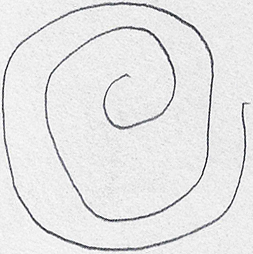

In [ ]:
import random
from PIL import Image

# 1. Get all image paths
image_path_list = list(data_path.glob("spiral/**/*.png"))

# 2. Pick a random image path
random_image_path = random.choice(image_path_list)

print(random_image_path)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem
print(image_class)

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

In [ ]:
train_dir = image_path / "training"
test_dir = image_path / "testing"

train_dir, test_dir

(PosixPath('drawings/spiral/training'), PosixPath('drawings/spiral/testing'))

## Transform Data

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import v2

In [ ]:
# No data augmentation for now
data_transform=transforms.Compose([
        transforms.RandomRotation(10),      # rotate +/- 10 degrees
        transforms.RandomHorizontalFlip(0.3),  # reverse 50% of images
        transforms.RandomVerticalFlip(0.3),
        transforms.Resize(224),             # resize shortest side to 224 pixels
        transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
        transforms.ToTensor(),
        # transforms.Normalize([0.485, 0.456, 0.406],
        #                      [0.229, 0.224, 0.225])
])

In [ ]:
# data_transform(img).shape

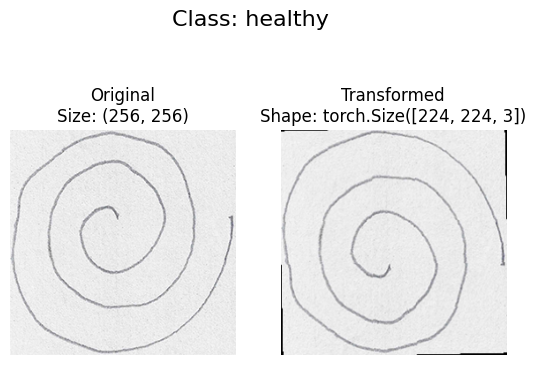

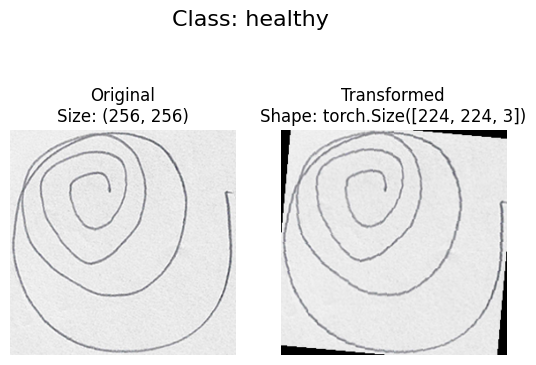

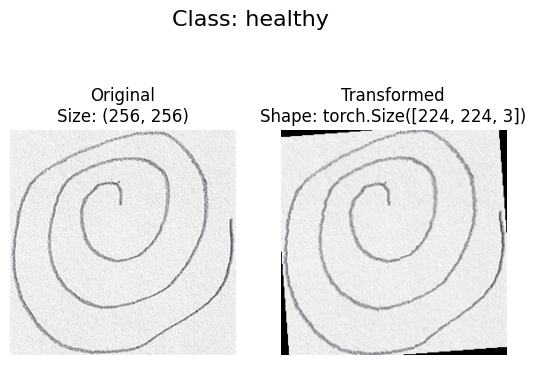

In [ ]:
# Plot transformed images
import numpy as np
import matplotlib.pyplot as plt

def plot_transformed_images(image_paths: list, transform, n=3, seed=None):
  """
  Selects random images from a path of images and loads/transforms
  them then plots the original vs the transformed version.
  """
  if seed:
    random.seed(seed)
  random_image_paths = [image_path_list[54], image_path_list[51], image_path_list[52]]
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize: {f.size}")
      ax[0].axis(False)

      # Transform and plot target image
      transformed_image=transform(f).permute(1, 2, 0) # changes shape from color_channels first (what PyTorch uses) to color_channels last (what matplotlib uses)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
      ax[1].axis("off")

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_paths=image_path_list,
                        transform=data_transform,
                        n=3)

In [ ]:
# ImageFolder to create datasets

from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,
                                  target_transform=None) # transform for labels

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 72
     Root location: drawings/spiral/training
     StandardTransform
 Transform: Compose(
                RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
                RandomHorizontalFlip(p=0.3)
                RandomVerticalFlip(p=0.3)
                Resize(size=224, interpolation=bilinear, max_size=None, antialias=True)
                CenterCrop(size=(224, 224))
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 30
     Root location: drawings/spiral/testing
     StandardTransform
 Transform: Compose(
                RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
                RandomHorizontalFlip(p=0.3)
                RandomVerticalFlip(p=0.3)
                Resize(size=224, interpolation=bilinear, max_size=None, antialias=True)
                CenterCrop(size=(224, 224))
                ToTensor()
            ))

In [ ]:
class_names = train_data.classes
class_names

['healthy', 'parkinson']

In [ ]:
class_dict = train_data.class_to_idx
class_dict

{'healthy': 0, 'parkinson': 1}

In [ ]:
len(train_data), len(test_data)

(72, 30)

In [ ]:
train_data.samples[0]

('drawings/spiral/training/healthy/V01HE02.png', 0)

In [ ]:
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n {img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
 tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
Image shape: torch.Size([3, 224, 224])
Image datatype: torch.float32
Image label: 0
Label datatype: <class 'int'>


In [ ]:
class CNNPD(nn.Module):
  """
  Model architecture copying TinyVGG from CNN Explainer
  """
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int) -> None:
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2,
                     stride=2),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2,
                     stride=2), # stride default = kernel_size
        nn.Conv2d(in_channels=hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2,
                     stride=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*676,
                  out_features=110),
        nn.ReLU(),
        nn.Linear(in_features=110,
                  out_features=90),
        nn.ReLU(),
        nn.Linear(in_features=90,
                  out_features=33),
        nn.ReLU(),
        nn.Linear(in_features=33,
                  out_features=output_shape)
    )

  def forward(self, x):
    return self.classifier(self.conv_block_1(x))

## KFold Cross Validation

In [ ]:
# train function
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device=device,
              ) -> None:
  # Put the model in train mode
  model.train()

  train_loss, train_acc = 0, 0
  # Loop through data loader data batches
  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)

    # 1. Forward pass
    y_pred = model(X) # outputs logits

    # 2. Calc the loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    # Calculate the accuracy
    train_pred_labels = y_pred.argmax(dim=1)
    train_acc += ((train_pred_labels==y).sum().item()/len(train_pred_labels))

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

  # Adjust metrics to get average loss and accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc


In [ ]:
# Test/validation step
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device = device):
  # put model in eval mode
  model.eval()

  # Setup test loss and test accuracy vals
  test_loss, test_acc = 0, 0

  with torch.inference_mode():
    # Loop through DataLoader batches
    for batch, (X, y) in enumerate(dataloader):
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      test_pred_logits = model(X)

      # 2. Calculate the loss
      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()

      # Calculate the accuracy
      test_pred_labels = test_pred_logits.argmax(dim=1)
      test_acc += ((test_pred_labels==y).sum().item()/len(test_pred_labels))

  # Adjust metrics to get average loss and accuracy per batch
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

In [ ]:
from sklearn.model_selection import KFold
from tqdm.auto import tqdm

model = CNNPD(input_shape = 3,
              hidden_units=128,
              output_shape=2).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss()

k_folds = 3
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
num_epochs = 250
batch_size = 16

train_loss_array = []
train_acc_array = []
val_loss_array = []
val_acc_array = []

for fold, (train_indices, val_indices) in tqdm(enumerate(kf.split(train_data))):
  print(f"Fold {fold + 1}/{k_folds}")

  train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
  val_sampler = torch.utils.data.SubsetRandomSampler(val_indices)

  train_loader = DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
  val_loader = DataLoader(train_data, batch_size=batch_size, sampler=val_sampler)

  train_loss_array_fold = []
  train_acc_array_fold = []
  val_loss_array_fold = []
  val_acc_array_fold = []

  for epoch in range(num_epochs):
    t_loss, t_acc = train_step(model=model,
                               dataloader=train_loader,
                               loss_fn=loss_fn,
                               optimizer=optimizer,
                               device=device)
    if (epoch % 25 == 0):
      train_loss_array_fold.append(t_loss)
      train_acc_array_fold.append(t_acc)

    val_loss, val_acc = test_step(model=model,
                                  dataloader=val_loader,
                                  loss_fn=loss_fn,
                                  device=device)
    if (epoch % 25 == 0):
      val_loss_array_fold.append(val_loss)
      val_acc_array_fold.append(val_acc)

  print(f"Validation results for Fold {fold + 1}:\n Validation Loss: {val_loss}\n Validation Accuracy: {val_acc}")
  train_loss_array.append(train_loss_array_fold)
  train_acc_array.append(train_acc_array_fold)
  val_loss_array.append(val_loss_array_fold)
  val_acc_array.append(val_acc_array_fold)

0it [00:00, ?it/s]

Fold 1/3
Validation results for Fold 1:
 Validation Loss: 2.4391563832759857
 Validation Accuracy: 0.65625
Fold 2/3
Validation results for Fold 2:
 Validation Loss: 0.0035873234301107004
 Validation Accuracy: 1.0
Fold 3/3
Validation results for Fold 3:
 Validation Loss: 0.013409181163297035
 Validation Accuracy: 1.0


In [ ]:
batch_size=16
test_dataloader = DataLoader(dataset=test_data,
                               batch_size=batch_size,
                               shuffle=True)

test_loss, test_acc = test_step(model=model,
                                dataloader=test_dataloader,
                                loss_fn=loss_fn,
                                device=device)

print(f"Test Loss: {test_loss} | Test Accuracy: {test_acc} | Val Accuracy: {val_acc}")

Test Loss: 3.6475319862365723 | Test Accuracy: 0.7008928571428572 | Val Accuracy: 1.0


In [ ]:
X_test = []
y_test = []

with torch.no_grad():
    for batch in test_dataloader:
        inputs, labels = batch
        X_test.append(inputs)
        y_test.append(labels)

# Concatenate the lists to obtain the final arrays
X_test = torch.cat(X_test, dim=0).to(device)
y_test = torch.cat(y_test, dim=0).to(device)

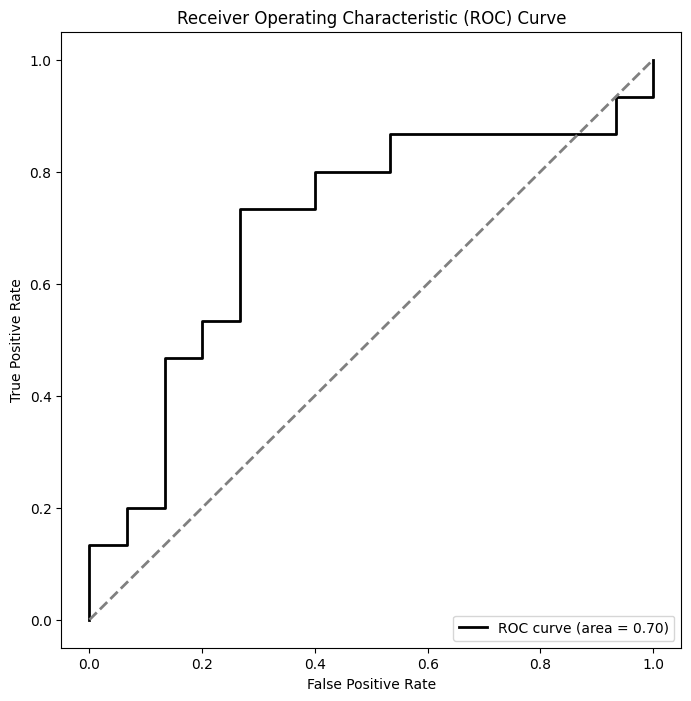

ROC AUC: 0.7022222222222222


In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    y_probs = model(X_test)

y_test = y_test.cpu().numpy().ravel()  # Convert to NumPy array and flatten
y_probs = y_probs.cpu().numpy()

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs[:, 1])

# Calculate ROC AUC
roc_auc = roc_auc_score(y_test, y_probs[:, 1])

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='black', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

print('ROC AUC:', roc_auc)


In [ ]:
for fold in train_loss_array:
  for num in fold:
    print(f"{num} ")

  print("\n")


0.7338495453198751 
0.6917881766955057 
0.6891252398490906 
0.6850464145342509 
0.28026188785831135 
0.15029821544885635 
0.06742693049212296 
0.010596496363480886 
0.04360653723900517 
0.0006337186932796612 


0.8594109788537025 
0.08164876078565915 
0.03571537951938808 
0.004906820642645471 
0.07954675424844027 
0.013756706311445063 
0.0004654537430421139 
7.540604565292597e-05 
3.19018284547686e-05 
9.082421396063485e-05 


0.17380637862030804 
0.022065651525432866 
8.61105004332785e-05 
0.0005038329545641318 
6.70801849385801e-05 
0.0001403139928394618 
0.007543909625534677 
0.0018619072701161106 
0.0006346270868865153 
0.0003027364073204808 




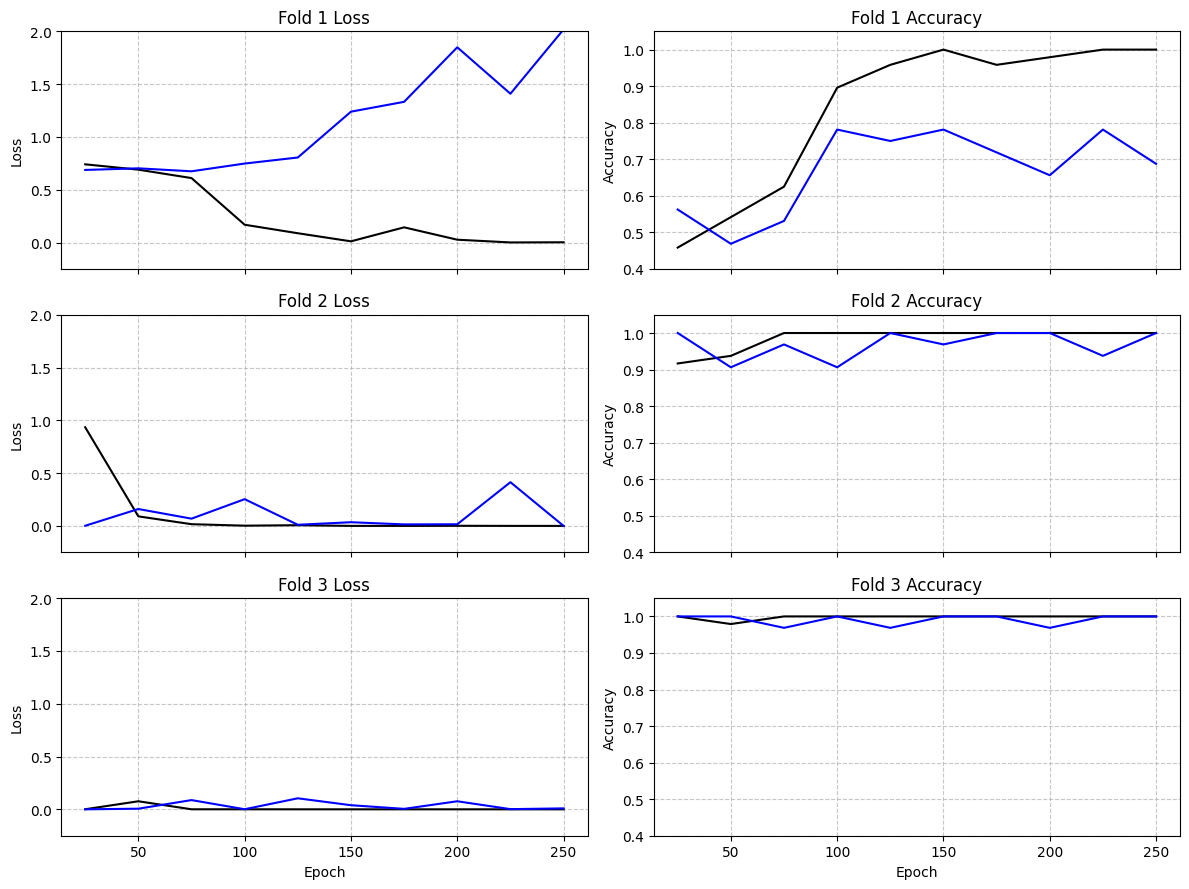

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import make_interp_spline

def plot_loss_accuracy_curves_subplots(train_losses_list, val_losses_list, train_accuracies_list, val_accuracies_list):
    num_folds = len(train_losses_list)  # Assuming the same number of folds for train and val

    # Generate epochs for every 25th epoch up to 250 epochs
    epochs = range(25, 251, 25)

    num_rows = num_folds  # Each fold on a separate row
    num_cols = 2  # Two columns for loss and accuracy plots
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 3 * num_rows), sharex=True)

    for fold in range(num_folds):
        # Smoothing the lines with spline interpolation
        spline_epochs = np.linspace(min(epochs), max(epochs), 100)
        spline_train_losses = make_interp_spline(epochs, train_losses_list[fold], k=1)(spline_epochs)
        spline_val_losses = make_interp_spline(epochs, val_losses_list[fold], k=1)(spline_epochs)
        spline_train_accuracies = make_interp_spline(epochs, train_accuracies_list[fold], k=1)(spline_epochs)
        spline_val_accuracies = make_interp_spline(epochs, val_accuracies_list[fold], k=1)(spline_epochs)

        axs[fold, 0].plot(spline_epochs, spline_train_losses, color="black", label=f'Train Loss (Fold {fold + 1})', marker='o', markersize=0)
        axs[fold, 0].plot(spline_epochs, spline_val_losses, color="blue", label=f'Validation Loss (Fold {fold + 1})', marker='o', markersize=0)

        axs[fold, 1].plot(spline_epochs, spline_train_accuracies, color="black", label=f'Train Accuracy (Fold {fold + 1})', marker='o', markersize=0)
        axs[fold, 1].plot(spline_epochs, spline_val_accuracies, color="blue", label=f'Validation Accuracy (Fold {fold + 1})', marker='o', markersize=0)

        axs[fold, 0].set_title(f'Fold {fold + 1} Loss', fontsize=12)
        axs[fold, 1].set_title(f'Fold {fold + 1} Accuracy', fontsize=12)

        axs[fold, 0].set_ylabel('Loss', fontsize=10)
        axs[fold, 1].set_ylabel('Accuracy', fontsize=10)

        axs[fold, 0].grid(True, linestyle='--', alpha=0.7)
        axs[fold, 1].grid(True, linestyle='--', alpha=0.7)

        # Set y-axis limits for loss and accuracy
        axs[fold, 0].set_ylim(-0.25, 2)
        axs[fold, 1].set_ylim(0.4, 1.05)

        # axs[fold, 0].legend()
        # axs[fold, 1].legend()

    axs[num_folds - 1, 0].set_xlabel('Epoch', fontsize=10)
    axs[num_folds - 1, 1].set_xlabel('Epoch', fontsize=10)

    plt.tight_layout()
    plt.show()

# Assuming train_loss_array, val_loss_array, train_acc_array, val_acc_array are defined
plot_loss_accuracy_curves_subplots(train_loss_array, val_loss_array, train_acc_array, val_acc_array)


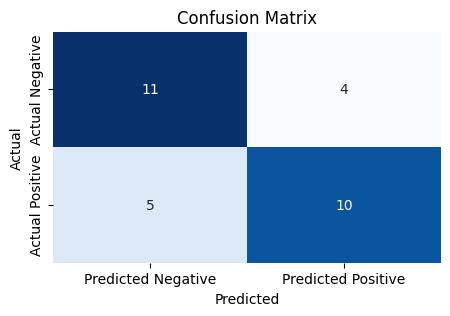

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

with torch.inference_mode():
  y_probs = model(X_test)
y_pred = torch.argmax(y_probs,dim=1)
cm = confusion_matrix(y_test, y_pred.cpu().numpy())

plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.metrics import classification_report,accuracy_score

print("Accuracy: "+str(accuracy_score(y_test, y_pred.cpu().numpy()))) #make confusion matrix
print('\n')
print(classification_report(y_test, y_pred.cpu().numpy())) # healthy is 0.0, parkinson's is 1.0

Accuracy: 0.7


              precision    recall  f1-score   support

           0       0.69      0.73      0.71        15
           1       0.71      0.67      0.69        15

    accuracy                           0.70        30
   macro avg       0.70      0.70      0.70        30
weighted avg       0.70      0.70      0.70        30



## Histogram of Oriented Gradients Test

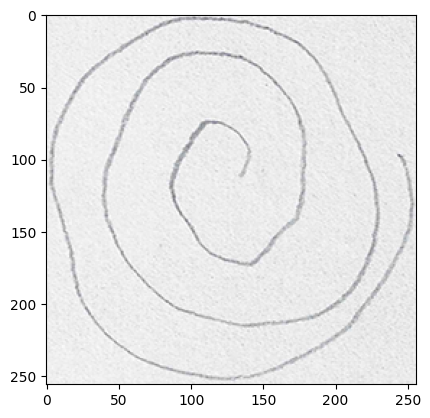

In [ ]:
img = Image.open(random_image_path)
plt.imshow(img)

In [ ]:
from skimage.io import imread
from skimage.transform import resize
from skimage.feature import hog
from skimage import exposure
import matplotlib.pyplot as plt

[[[239 239 239]
  [240 240 240]
  [242 242 242]
  ...
  [237 237 237]
  [237 237 237]
  [233 233 233]]

 [[236 236 236]
  [235 235 235]
  [237 237 237]
  ...
  [233 233 233]
  [237 237 237]
  [240 240 240]]

 [[241 241 241]
  [235 235 235]
  [240 240 240]
  ...
  [230 230 230]
  [228 228 228]
  [236 236 236]]

 ...

 [[240 240 240]
  [247 247 247]
  [244 244 244]
  ...
  [234 234 234]
  [240 240 240]
  [241 241 241]]

 [[236 236 236]
  [238 238 238]
  [245 245 245]
  ...
  [231 231 231]
  [239 239 239]
  [240 240 240]]

 [[238 238 238]
  [235 235 235]
  [240 240 240]
  ...
  [228 228 228]
  [235 235 235]
  [237 237 237]]]


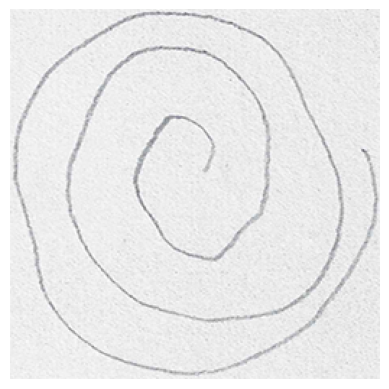

In [ ]:
img = imread(random_image_path)
plt.axis("off")
plt.imshow(img)
print(img)

(128, 64, 3)


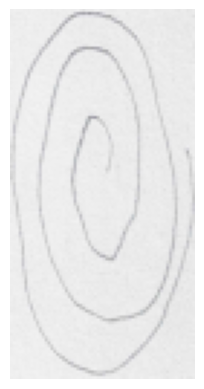

In [ ]:
resized_img = resize(img, (128, 64))
plt.axis("off")
plt.imshow(resized_img)
print(resized_img.shape)

<ipython-input-39-ea2f3015bb4d>:1: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  fd, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(8, 8),


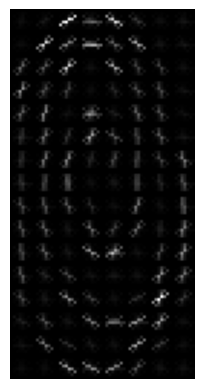

In [ ]:
fd, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(8, 8),
                	cells_per_block=(2, 2), visualize=True, multichannel=True)
plt.axis("off")
plt.imshow(hog_image, cmap="gray")

In [ ]:
fd.shape

(3780,)